# Generador de no-postulados random
Este notebook toma un archivo preprocesado de no postulaciones random y mediante un Random Forest realiza un refinamiento iterativo eliminando aquellos registros random con alta probabilidad de ser falsa.

La idea sería algo del estilo aprendizaje semi-supervisado

**El mismo resultado que genera este notebook se puede obtener corriendo generar_no_postulados.py**

In [1]:
import math

import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score

%matplotlib inline

## Constantes definidas
- `DATASET_SAMPLE_SIZE`: La cantidad de registros que se desean mantener
- `TEST_SIZE_PERCENT`: Define el porcentaje del set de entrenamiento que se utilizará para validar los entrenamientos. Es a fines informativos, la información no se utiliza para realimentar el proceso.
- `RANDOM_SEED`: Se utiliza una semilla aleatoria fija para que el test se mantenga determinista.
- `MIN_SAMPLES_NO_POSTULADOS`: Mínima cantidad de samples que deben entrar en una iteración. Para evitar que el filtro elimine todo.

In [2]:
DATASET_SAMPLE_SIZE = 500000

# Porcentaje del set de entrenamiento que se usa para validar
TEST_SIZE_PERCENT = 0.2

# Semilla aleatoria fija para mantener la ejecución determinista.
RANDOM_SEED = 12

# Umbral de probabilidad aceptable para considerar una no postulación predicha como válida
#UMBRAL_PROB_NO_POSTULADO = 0.25

# Mínima cantidad de no postulados para agregar en una iteración
MIN_SAMPLES_NO_POSTULADOS = 10

### Los archivos ya deben tener los features creados. 

Ambos archivos se crearon de la siguiente forma: 
- Ejecutar el notebook `generar_set_test.ipynb`
- Ejecutar `python3 preprocesar_set.py test.csv test-preprocesado.csv` para cada archivo CSV.

In [3]:
entrenamiento = pd.read_csv('/home/luciano/orga-datos/training-set-no-random-preprocesado.csv')
no_postulados = pd.read_csv('/home/luciano/orga-datos/training-set-no-postulados-random-preprocesado.csv')

In [4]:
entrenamiento.head()

,idaviso,idpostulante,edad_postulante,sexo_postulante,nivel_educativo_postulante,hay_informacion_basica,num_vistas,cantidad_vistas,cantidad_postulaciones,cant_vistas_nombre_area,...,cant_postulaciones_nombre_area,cant_postulaciones_nombre_zona,cant_postulaciones_tipo_de_trabajo,cant_postulaciones_denominacion_empresa,desc_score,edad_media,sexo_medio,nivel_educativo_medio,hay_informacion_media_aviso,sepostulo
0,1112370921,LNKj9Jr,25.0,-1.0,4.0,1,1,12,5,2,...,1,4,1,1,153,30.370326,-0.363088,2.838359,1,1
1,1112353843,YdDO2V,34.0,1.0,4.0,1,1,35,38,5,...,4,34,34,2,669,33.182573,0.867220,3.607884,1,0
2,1112448587,6QY4DR,50.0,-1.0,4.0,1,3,308,70,18,...,0,189,9,0,1053,25.934911,-0.137081,2.238412,1,0
3,1112468192,wVYmGBL,34.0,1.0,4.0,1,1,129,27,32,...,12,46,34,0,1563,27.467018,0.189974,2.236148,1,0
4,1112451122,aa1LaN,36.0,1.0,6.0,1,2,49,3,18,...,2,3,3,0,210,28.613636,-0.186364,2.447727,1,0


In [5]:
X = entrenamiento.drop(axis=1, labels=['idaviso', 'idpostulante', 'sepostulo'])
y = entrenamiento['sepostulo']

In [6]:
no_postulados_set = no_postulados.drop(axis=1, labels=['idaviso', 'idpostulante'])

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE_PERCENT, random_state=RANDOM_SEED)

In [8]:
clasificador = RandomForestClassifier(
        n_estimators=10, 
        criterion='entropy', 
        max_features='sqrt', 
        min_samples_split=20, 
        n_jobs=-1, 
        random_state=RANDOM_SEED, 
        verbose=10
    )

In [9]:
clasificador.fit(X_train, y_train)

building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10


[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:   10.4s remaining:   10.4s


building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   12.2s remaining:    5.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   16.3s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=20,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=12, verbose=10, warm_start=False)

In [10]:
print('Score vs set train:', clasificador.score(X_train, y_train))
print('Score vs set test:', clasificador.score(X_test, y_test))

[Parallel(n_jobs=4)]: Done   5 out of  10 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.7s finished


Score vs set train: 0.96712875
Score vs set test: 0.93791


[Parallel(n_jobs=4)]: Done   5 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.2s finished


### Comienzo del proceso iterativo

Esta celda sirve para iniciar/reiniciar las iteraciones.

In [11]:
iteracion = 0
MAX_ITERACIONES = 10
no_postulados['sepostulo'] = 0
no_postulados['sepostulo_acum'] = 0

# for:
#### Desde acá arranca un proceso iterativo. Si se quieren hacer 10 iteraciones, las siguientes celdas se ejecutan 10 veces.

In [162]:
assert iteracion <= MAX_ITERACIONES
print('Iteracion actual:', iteracion, 'de', MAX_ITERACIONES)

Iteracion actual: 10 de 10


In [163]:
np_sepostulo = pd.DataFrame(clasificador.predict_proba(no_postulados_set)[:, 1], columns=['sepostulo'])

[Parallel(n_jobs=4)]: Done   5 out of  10 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.4s finished


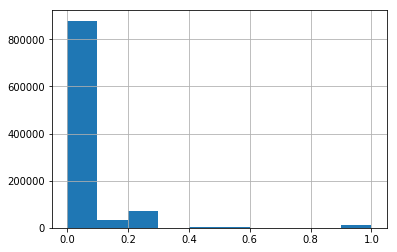

In [164]:
np_sepostulo['sepostulo'].hist()

In [165]:
no_postulados['sepostulo_acum'] += np_sepostulo['sepostulo']
no_postulados['sepostulo'] = no_postulados['sepostulo_acum'] / (iteracion + 1)

### Fórmula para determinar el umbral de probabilidades aceptado

Debido a que en las primeras iteraciones la predicción es muy mala, se debe filtrar con una probabilidad alta de aceptar; a medida que el proceso avanza, la probabilidad se va reduciendo para producir un refinamiento.

Para esto se utilizó una fórmula (definida y probada empíricamente) que inicia con probabilidad menor a 0.5 para aceptar un no postulado y finaliza con una probabilidad cercana a 0.1. La fórmula decae como e^-x

In [166]:
# En cada iteración la probabilidad de aceptar un no-postulado es menor, con base en 0.5 y asintótica en 0.1
BASE = 0.5
ASINT = 0.1
prob = lambda x: math.e ** -( ((1.5 * x)/MAX_ITERACIONES) - math.log(BASE) ) 
#prob_no_postulado = UMBRAL_PROB_NO_POSTULADO * ((total_iteraciones - iteracion + 1) / total_iteraciones)
prob_no_postulado = prob(iteracion)
print('Probabilidad de ser 0 para agarrar un no-postulado:', prob_no_postulado)

Probabilidad de ser 0 para agarrar un no-postulado: 0.11156508007421492


In [167]:
print(len(no_postulados[no_postulados['sepostulo'] < prob_no_postulado]))
# Prevenir que el umbral elimine todos los resultados
assert len(no_postulados[no_postulados['sepostulo'] < prob_no_postulado]) > MIN_SAMPLES_NO_POSTULADOS
# Si este assert falla: Verificar UMBRAL_PROB_NO_POSTULADO, MIN_SAMPLES_NO_POSTULADOS, total_iteraciones

706803


### Tope de no-postulados

Para evitar que el set quede desbalanceado, si la cantidad de resultados devueltos por el filtro es mayor a `DATASET_SAMPLE_SIZE` se toma una muestra de este tamaño de modo que las tres "clases" queden con una misma probabilidad.

Esto, sin embargo, deja las clases reales desbalanceadas ya que hay un 33% de postulaciones y un 66% de no postulaciones, pero este problema se resolverá al probar el set final.

In [168]:
no_post_to_concat = no_postulados[no_postulados['sepostulo'] < prob_no_postulado]

if len(no_post_to_concat) > DATASET_SAMPLE_SIZE:
    no_post_to_concat = no_post_to_concat.sample(n=DATASET_SAMPLE_SIZE)

nuevo_entrenamiento = pd.concat([entrenamiento, no_post_to_concat.drop(axis=1, labels=['sepostulo_acum'])])

In [169]:
nuevo_entrenamiento.loc[nuevo_entrenamiento['sepostulo'] < prob_no_postulado, 'sepostulo'] = 0

In [170]:
nuevo_entrenamiento['sepostulo'] = nuevo_entrenamiento['sepostulo'].astype('int')

In [171]:
X = nuevo_entrenamiento.drop(axis=1, labels=['idaviso', 'idpostulante', 'sepostulo'])
y = nuevo_entrenamiento['sepostulo']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE_PERCENT, random_state=RANDOM_SEED)

In [172]:
clasificador.fit(X_train, y_train)

building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10


[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:   15.0s remaining:   15.0s


building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   15.4s remaining:    6.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   22.1s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=20,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=12, verbose=10, warm_start=False)

In [173]:
print('Score vs set train:', clasificador.score(X_train, y_train))
print('Score vs set test:', clasificador.score(X_test, y_test))

[Parallel(n_jobs=4)]: Done   5 out of  10 | elapsed:    0.6s remaining:    0.6s
[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:    0.7s remaining:    0.3s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.9s finished


Score vs set train: 0.9784033333333333


[Parallel(n_jobs=4)]: Done   5 out of  10 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.2s finished


Score vs set test: 0.9586833333333333


In [174]:
m = pd.DataFrame(clasificador.predict_proba(no_postulados_set)[:, 1], columns=['sepostulo'])

[Parallel(n_jobs=4)]: Done   5 out of  10 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.4s finished


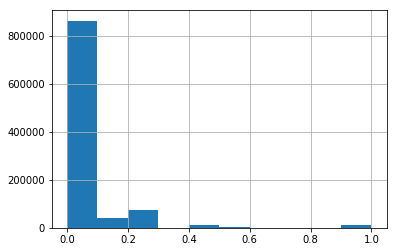

In [175]:
m['sepostulo'].hist()

In [176]:
iteracion += 1

# endfor
#### Hasta acá el proceso iterativo

### Guardar resultados 

A partir de acá se guardan los siguientes archivos CSV:

- no-postulantes-random-confirmados.csv: La cantidad de no postulaciones indicada en DATASET_SAMPLE_SIZE
- training-set-final.csv: Set de entrenamiento final. Tiene 3 * DATASET_SAMPLE_SIZE filas (postulaciones, vistas no postuladas, no postulaciones)

In [177]:
np_sepostulo = pd.DataFrame(clasificador.predict_proba(no_postulados_set)[:, 1], columns=['sepostulo'])

[Parallel(n_jobs=4)]: Done   5 out of  10 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.4s finished


In [179]:
no_postulados['sepostulo_acum'] += np_sepostulo['sepostulo']

In [181]:
no_postulados['sepostulo'] = no_postulados['sepostulo_acum'] / (iteracion + 1)

In [188]:
no_postulados_al_set = no_postulados[no_postulados['sepostulo'] < 0.1].sample(n=DATASET_SAMPLE_SIZE)

In [190]:
no_postulados_al_set['sepostulo'] = 0

In [191]:
no_postulados_al_set.to_csv('/home/luciano/orga-datos/no-postulados-random-confirmados.csv', index=False)

In [192]:
len(no_postulados_al_set)

500000

In [193]:
len(entrenamiento)

1000000

In [196]:
set_test_completo = pd.concat([entrenamiento, no_postulados_al_set.drop(axis=1, labels=['sepostulo_acum'])])

In [197]:
set_test_completo = set_test_completo.sample(frac=1)

In [198]:
set_test_completo.to_csv('/home/luciano/orga-datos/training-set-final.csv', index=False)